# Download dataset

## method1. upload dataset manually (slow)

In [ ]:
from google.colab import files
uploaded = files.upload()

## method 2. faster way using kaggle command ( please check https://www.kaggle.com/general/74235)

In [2]:
#1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

#2. Click on Create New API Token - It will download kaggle.json file on your machine.

#3. Go to your Google Colab project file and run the following commands:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c computer-vision-hw4-2023

mkdir: cannot create directory ‘/root/.kaggle’: File exists
computer-vision-hw4-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


## You can put the dataset in Google Drive by running the following commands

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [3]:
# unzip dataset
!kaggle competitions download -c computer-vision-hw4-2023
!unzip computer-vision-hw4-2023.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: ccpd6000/test_images/1001.jpg  
  inflating: ccpd6000/test_images/1002.jpg  
  inflating: ccpd6000/test_images/1003.jpg  
  inflating: ccpd6000/test_images/1004.jpg  
  inflating: ccpd6000/test_images/1005.jpg  
  inflating: ccpd6000/test_images/1006.jpg  
  inflating: ccpd6000/test_images/1007.jpg  
  inflating: ccpd6000/test_images/1008.jpg  
  inflating: ccpd6000/test_images/1009.jpg  
  inflating: ccpd6000/test_images/1010.jpg  
  inflating: ccpd6000/test_images/1011.jpg  
  inflating: ccpd6000/test_images/1012.jpg  
  inflating: ccpd6000/test_images/1013.jpg  
  inflating: ccpd6000/test_images/1014.jpg  
  inflating: ccpd6000/test_images/1015.jpg  
  inflating: ccpd6000/test_images/1016.jpg  
  inflating: ccpd6000/test_images/1017.jpg  
  inflating: ccpd6000/test_images/1018.jpg  
  inflating: ccpd6000/test_images/1019.jpg  
  inflating: ccpd6000/test_images/1020.jpg  
  inflating: ccpd6000/test_images/1021.jpg  
  inflating: ccpd6000/test_images/

In [ ]:
!nvidia-smi

Mon Dec 18 07:36:33 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Init and Utility

In [4]:
! pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=8fbe06738c92f24b6dbbf496deeb15083b3745fbab167effdf4c607e1be3f5de
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [5]:
import warnings
import os
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython import display
from skimage import util
from skimage.transform import ProjectiveTransform, warp

import numpy as np
import random
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import torchvision.models as models
import cv2
import shutil
import warnings
from efficientnet_pytorch import EfficientNet
from torch import nn, optim
from torch.optim import lr_scheduler
from torchsummary import summary

In [6]:
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [7]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

def draw_plate(img, kpts):
    '''Perspective tranform and draw the plate indicated by kpts to a 96x30 rectangle.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
    Return:
        img: (PIL.Image) modified image
    Reference: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    '''
    src = np.float32([[96, 30], [0, 30], [0, 0], [96, 0]])
    dst = kpts.view(4, 2).numpy()
    dst = dst * np.float32(img.size)

    transform = ProjectiveTransform()
    transform.estimate(src, dst)
    with warnings.catch_warnings(): # surpress skimage warning
        warnings.simplefilter("ignore")
        warped = warp(np.array(img), transform, output_shape=(30, 96))
        warped = util.img_as_ubyte(warped)
    plate = Image.fromarray(warped)
    img.paste(plate)
    return img

# Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


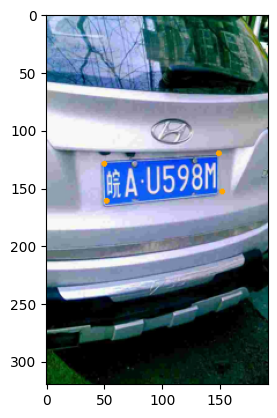

In [8]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of
                bottom-right, bottom-left, top-left, top-right corners.
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img_path = self.img_paths[idx]

        # load image
        img = Image.open(img_path)
        W, H = img.size
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)

        # parse annotation
        kpt = self.anns[idx]
        kpt = list(kpt.values())[1:9]
        kpt = torch.tensor(kpt) # [8,]
        kpt = kpt.view(4, 2) # [4, 2]
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1) # [8,]

        return img, kpt


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

# Network

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary

        # TODO : add more layers to achieve better performance
        model = EfficientNet.from_pretrained('efficientnet-b3')
        #in_features = self.efficient_net._fc.in_features
        #self.features = nn.Sequential(nn.Conv2d(3,3,(3,3),stride=1,padding=1),nn.ReLU(inplace=True),model)
        self.features = nn.Sequential(nn.Conv2d(3,3,(3,3)),model)
        #self.features = self.efficient_net.extract_features
        # TODO : add ouput layer to predict position
        # Note : the orginal kpts of data have been normalized (0-1)
        self.regression = nn.Linear(1000,8)

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        features = self.features(img_b)
        kpt_b = self.regression(features)
        return kpt_b


# Do some checking
loader = DataLoader(data, batch_size=32) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)
total_params = sum(p.numel() for p in model.parameters())
print(f'Total Parameters (Trainable + Non-trainable): {total_params}')

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Trainable Parameters: {total_trainable_params}')

torch.Size([32, 3, 320, 192])
torch.Size([32, 8])


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 284MB/s]


Loaded pretrained weights for efficientnet-b3
tensor(0.5877, device='cuda:0', grad_fn=<MeanBackward0>)
Total Parameters (Trainable + Non-trainable): 12241324
Total Trainable Parameters: 12241324


# Training

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loaded pretrained weights for efficientnet-b3
lr: 9e-05
Epoch 000:
train loss: 0.218211967839549
valid loss: 0.142466489225626
lr: 9e-05
Epoch 001:
train loss: 0.1043329901372393
valid loss: 0.07492946938922009
lr: 9e-05
Epoch 002:
train loss: 0.07896262047191462
valid loss: 0.05638388997564713
lr: 9e-05
Epoch 003:
train loss: 0.0629882097709924
valid loss: 0.04261934027696649
lr: 9e-05
Epoch 004:
train loss: 0.051502329080055156
valid loss: 0.040378165803849696
lr: 9e-05
Epoch 005:
train loss: 0.044958780775777994
valid loss: 0.03771211852629979
lr: 9e-05
Epoch 006:
train loss: 0.03879828279217084
valid loss: 0.026873810372004907
lr: 9e-05
Epoch 007:
train loss: 0.03456505908786009
valid loss: 0.025370692647993565
lr: 9e-05
Epoch 008:
train loss: 0.03243983758147806
valid loss: 0.020581502777834732
lr: 9e-05
Epoch 009:
train loss: 0.030240516170548896
valid loss: 0.021174678454796474
lr: 9e-05
Epoch 010:
train loss: 0.027353375125676392
valid loss: 0.017728921802093584
lr: 9e-05
Epoch

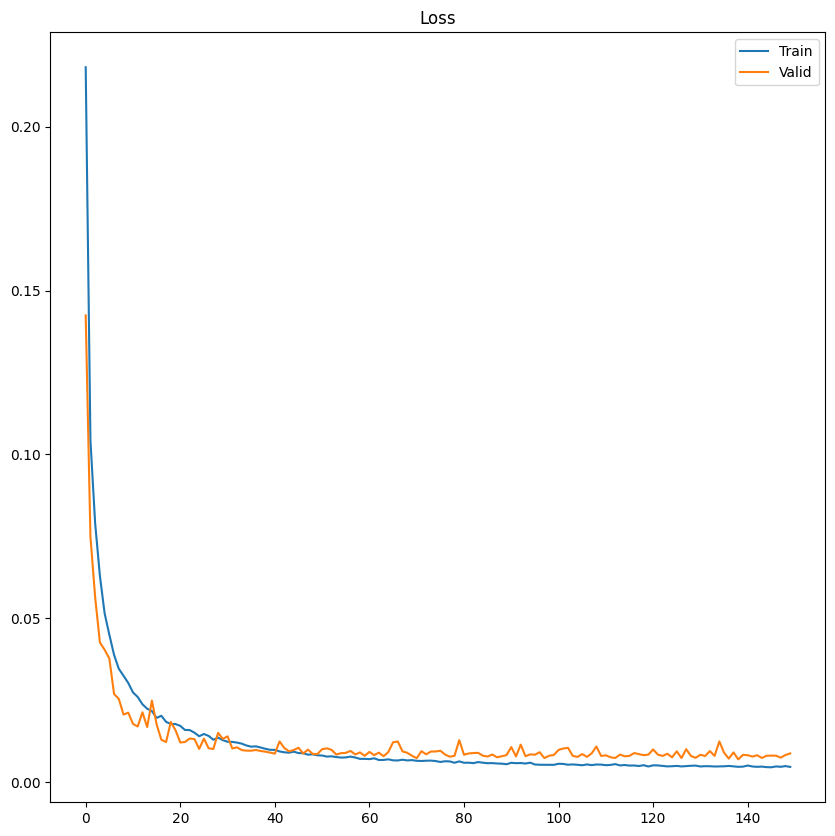

In [10]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))

        self.train_loader = DataLoader(self.train_set, 10, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False, num_workers=4)

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=9e-5)
        self.max_epoch = 150
        #TODO define your training epochs

    def run(self):
        training_result_dir = self.log_dir / 'training_result'
        training_result_dir.mkdir(parents=True)
        metrics = {'train_loss': [], 'valid_loss': []}

        for self.epoch in range(self.max_epoch): # epochs
            train_loss = self.train() # train 1 epoch
            valid_loss = self.valid() # valid 1 epoch
            print('lr:',get_lr(self.optimizer))
            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            # Save the parameters(weights) of the model to disk
            if torch.tensor(metrics['valid_loss']).argmin() == self.epoch:
                torch.save(self.model.state_dict(), str(training_result_dir / 'model.pth'))

        # Plot the loss curve against epoch
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
        ax.set_title('Loss')
        ax.plot(range(self.epoch + 1), metrics['train_loss'], label='Train')
        ax.plot(range(self.epoch + 1), metrics['valid_loss'], label='Valid')
        ax.legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'metrics.jpg'))
        plt.close()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        loss_steps = []
        mse_steps = []
        optimizer = optim.Adam(model.parameters(), lr=9e-5)
        #scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
        for img_b, kpt_b in iter(self.train_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            self.optimizer.zero_grad()
            pred_b = self.model(img_b)
            # TODO
            # step 1 caculate the loss
            #loss = F.mse_loss(pred_b, kpt_b)
            loss = self.criterion(pred_b, kpt_b)
            # step 2 back propagation
            loss.backward()

            # step 3 update parameters using optimizer
            self.optimizer.step()

            #scheduler.step()
            loss_steps.append(loss.detach().item())

        avg_loss = sum(loss_steps) / len(loss_steps)
        return avg_loss

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.valid_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            loss_steps.append(loss.detach().item())

        avg_loss = sum(loss_steps) / len(loss_steps)
        return avg_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

# Testing

In [11]:
# Do testing
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

#import utils
#from utils.model import CCPDRegressor
img_size=(192, 320)
class CCPDTest:
    def __init__(self, img_dir):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('./ccpd6000/test_images')
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=2)

device = 'cuda'
model = Net().to(device)
model.load_state_dict(torch.load(str(log_dir / 'training_result/model.pth')))
model.eval()

log_dir_test = Path('./testing_result') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir_test.mkdir(parents=True)
print(log_dir_test)

def test(pbar):
    model.eval()
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()

        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, kpt)
            vis = draw_kpts(vis, kpt, c='red')
            vis.save(log_dir_test / f'{pbar.n:03d}_vis.jpg')
            # Original image size: 720 * 1160
            kpt[0:-1:2] *= 720
            kpt[1::2] *= 1160
            anns.append([f'{pbar.n:04d}.jpg', *kpt.numpy().tolist()])
            pbar.update()

    return pd.DataFrame(anns)

with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv('./ccpd6000/test_pred.csv', float_format='%.5f', index=False)

Loaded pretrained weights for efficientnet-b3
testing_result/Dec.18 12:17:14


100%|██████████| 3000/3000 [01:14<00:00, 40.50it/s]


# **Report**

# CS6550 Computer Vision Homework 4
112062673 吳文雯


★Overlay training losses and validation losses in the same figure against each epoch.
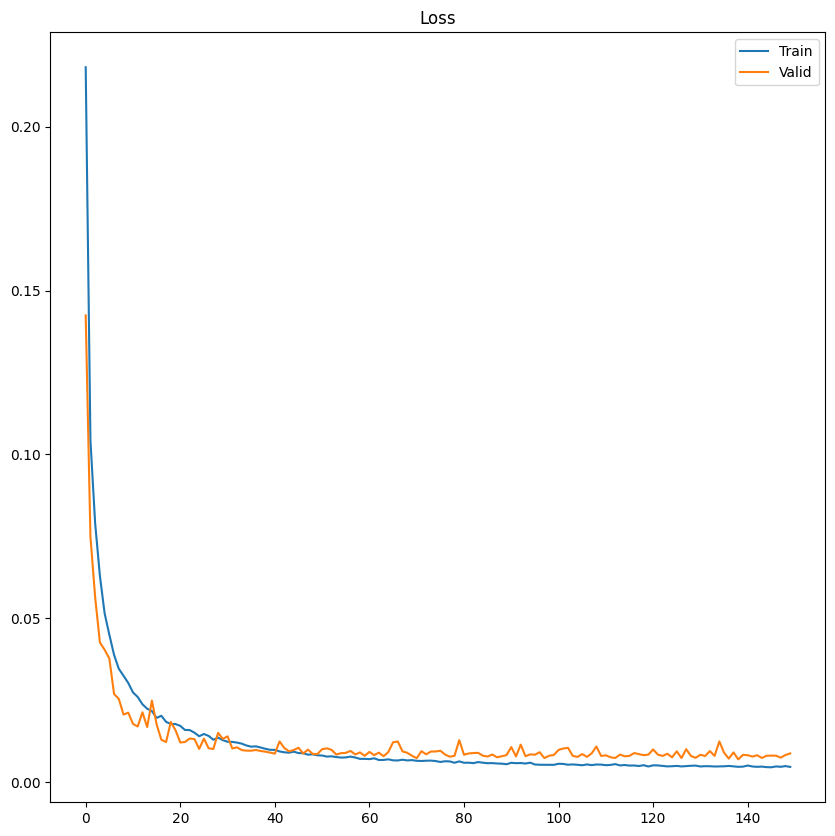**

★Visualization results of my final model on: (1)test_images/0000.jpg, (2)test_images/1000.jpg.


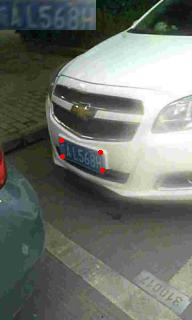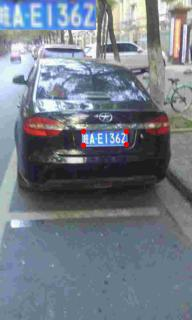

★The number of total parameters and trainable parameters.

12241324( ~12M) total
parameters, and 12241324 ( ~12M) trainable parameters.

★The hyperparameters(epochs, learning rate, loss function, optimizer) of your final model.

Epoch = 150

Learning rate = 9e-5

Loss function = nn.L1loss()

Optimizer = optim.Adam(model.parameters(), lr=9e-5)

★Describe and compare the methods I have tried in this project.


1. Network=nn.Conv2d+efficientNet-b1, epoch 30, lr=9e-4, loss=nn.L1loss

  score:12.37541

2. Network=nn.Conv2d+nn.RELU+efficientNet-b4, epoch 50, lr=9e-4, loss=nn.L1loss

  score: 33.91069

3. Network=nn.Conv2d+nn.RELU+efficientNet-b4, epoch 50, lr=9e-5, loss=nn.MSEloss

  score: 29.53271

4. Network=nn.Conv2d+nn.RELU+efficientNet-b2, epoch 35, lr=9e-6, loss=nn.L1loss

  score: 14.75475

5. Network=nn.Conv2d+efficientNet-b3, epoch 50, lr=9e-5, loss=nn.L1loss

  score: 10.20042
  
6. Network=nn.Conv2d+efficientNet-b3, epoch 150, lr=9e-5, loss=nn.L1loss

  score: 8.56963

Conclusion:
1. For solving this kind of problem, MSELoss is worse than L1loss. Although the value calculated by MSEloss is much lower, the testing results are quite bad.
2. When using efficientNet to be part of the network, adding nn.RELU is not a good choice. Also, the efficientNet-b3 has better performance than b0-b2. As for b4, i cannot exactly evaluate its performance since i did not use it with the same hyperparameters as the other versions.
3. Using smaller learning rate may require more time to train the model, but the result would be better.
4. Training the model with more epochs would take much time, but it would lead to better performance.